# EDA Lab + Homework (Student)

**Goal**: practice high-signal EDA like you would in a FAANG ML interview or on-call investigation.

Rules:
- Work top-to-bottom
- Don't hardcode outputs
- Prefer concise, high-signal plots


In [46]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def check(name: str, cond: bool):
    if not cond:
        raise AssertionError(f"Failed: {name}")
    print(f"OK: {name}")

rng = np.random.default_rng(0)

# Offline dataset (embedded CSV). Synthetic but realistic pitfalls: missingness, heavy tails, leakage-like columns.
CSV = """user_id,country,plan,signup_days_ago,tenure_days,sessions_last_7d,avg_session_min,age,discount_pct,last_payment_failed,churned,refund_after_churn_flag
1,US,basic,400,365,2,8.0,25,0.0,0,0,0
2,US,premium,120,110,18,22.0,41,10.0,0,0,0
  3,IN,basic,30,25,1,3.0,19,0.0,1,1,1
4,IN,basic,10,7,0,2.0,22,0.0,1,0,0
5,GB,premium,800,790,30,35.0,52,15.0,0,0,0
6,GB,basic,200,180,5,10.0,33,,1,1,1
7,US,basic,60,55,7,12.0,,0.0,0,0,0
8,CA,premium,90,80,14,18.0,29,5.0,0,0,0
9,CA,basic,15,12,0,1.0,24,0.0,1,1,1
10,IN,premium,300,280,20,25.0,38,20.0,0,0,0
11,US,premium,5,3,0,0.5,27,0.0,1,1,1
12,GB,premium,45,40,9,15.0,31,0.0,0,0,0
13,US,basic,500,490,1,6.0,47,0.0,0,0,0
14,IN,basic,75,70,4,9.0,28,0.0,0,0,0
15,CA,basic,365,360,3,7.0,36,0.0,0,0,0
16,US,premium,20,18,0,1.0,23,0.0,1,1,1
17,GB,basic,150,140,6,11.0,42,0.0,0,0,0
18,IN,premium,220,210,25,28.0,34,25.0,0,0,0
19,US,basic,12,10,0,0.2,21,0.0,1,1,1
20,CA,premium,600,590,22,26.0,55,0.0,0,0,0
"""

df = pd.read_csv(io.StringIO(CSV))
check('n_rows', df.shape[0] == 20)
check('has_target', 'churned' in df.columns)
df.head()


OK: n_rows
OK: has_target


,user_id,country,plan,signup_days_ago,tenure_days,sessions_last_7d,avg_session_min,age,discount_pct,last_payment_failed,churned,refund_after_churn_flag
0,1,US,basic,400,365,2,8.0,25.0,0.0,0,0,0
1,2,US,premium,120,110,18,22.0,41.0,10.0,0,0,0
2,3,IN,basic,30,25,1,3.0,19.0,0.0,1,1,1
3,4,IN,basic,10,7,0,2.0,22.0,0.0,1,0,0
4,5,GB,premium,800,790,30,35.0,52.0,15.0,0,0,0


## 1) Sanity Checks — 10 minutes


### Task 1.1: Data grain + schema


In [47]:
# TODO: write 1-2 sentences: what is the grain of this dataset? = each individual row
# if my grain is wrong, whenever we use groupby or aggregations, we may get incorrect results.
# my model may see duplicate rows or miss important variations between users.
# leakage means that information from the future (e.g., after churn) is used to predict the past.

# TODO: inspect dtypes; convert to appropriate types if needed

df.dtypes # tells data types of each column

# HINT: churned should be int/bool; categorical columns should remain object/category


user_id                      int64
country                     object
plan                        object
signup_days_ago              int64
tenure_days                  int64
sessions_last_7d             int64
avg_session_min            float64
age                        float64
discount_pct               float64
last_payment_failed          int64
churned                      int64
refund_after_churn_flag      int64
dtype: object

### Task 1.2: Missingness + duplicates


In [48]:
# TODO: build a missingness table with columns [n_missing, pct_missing] sorted desc
def missingness_table(df: pd.DataFrame) -> pd.DataFrame:
    n = len(df)
    
    n_missing = df.isna().sum() # computes number of missing values per column of dataframe df
    # print('n_missing:', n_missing)

    pct = (n_missing / n).sort_values(ascending=False) # computes percentage of missing values per column of dataframe df
    # print('pct:', pct)

    out = pd.DataFrame({'n_missing': n_missing, 'pct_missing': pct}) # creates a new dataframe with two columns n_missing and pct_missing
    #print(out)

    return out.sort_values(by='n_missing', ascending=False) # sorts the dataframe by n_missing in descending order

miss = missingness_table(df)
miss

# print(miss)

check('miss_has_cols', set(miss.columns) >= {'n_missing','pct_missing'})

# TODO: check duplicate rows and duplicate user_id
# df.duplicated() returns a boolean Series indicating whether each row is a duplicate of a previous row.
# sum() counts the number of True values as 1 and fasle values as 0.
n_dup_rows = int(df.duplicated().sum() ) # counts number of duplicate rows in dataframe df
n_dup_user_id = int(df['user_id'].duplicated().sum()) # counts number of duplicate user_id in dataframe df
print(n_dup_rows, n_dup_user_id)


OK: miss_has_cols
0 0


## 2) Distributions + Outliers — 15 minutes


### Task 2.1: Numeric summaries


In [49]:
# TODO: compute summary stats (mean/median/std/quantiles) for numeric columns
# HINT: Select only Numeric Columns

num = df.select_dtypes(include=[np.number]) # selects only numeric columns like int, float and other numpy numeric typesfrom dataframe df
# print(num)

# describe() computes summary statistics for numeric columns in dataframe num
summary = num.describe(percentiles=[0.25, 0.5, 0.75]).T # computes summary statistics for numeric columns in dataframe num
print(summary) 
summary


                         count        mean         std   min    25%    50%  \
user_id                   20.0   10.500000    5.916080   1.0   5.75   10.5   
signup_days_ago           20.0  200.850000  226.280514   5.0  27.50  105.0   
tenure_days               20.0  191.750000  222.845208   3.0  23.25   95.0   
sessions_last_7d          20.0    8.350000    9.615092   0.0   0.75    4.5   
avg_session_min           20.0   11.985000   10.464188   0.2   2.75    9.5   
age                       19.0   33.000000   10.561986  19.0  24.50   31.0   
discount_pct              19.0    3.947368    7.742191   0.0   0.00    0.0   
last_payment_failed       20.0    0.350000    0.489360   0.0   0.00    0.0   
churned                   20.0    0.300000    0.470162   0.0   0.00    0.0   
refund_after_churn_flag   20.0    0.300000    0.470162   0.0   0.00    0.0   

                            75%    max  
user_id                   15.25   20.0  
signup_days_ago          316.25  800.0  
tenure_days       

,count,mean,std,min,25%,50%,75%,max
user_id,20.0,10.500000,5.916080,1.0,5.75,10.5,15.25,20.0
signup_days_ago,20.0,200.850000,226.280514,5.0,27.50,105.0,316.25,800.0
tenure_days,20.0,191.750000,222.845208,3.0,23.25,95.0,300.00,790.0
sessions_last_7d,20.0,8.350000,9.615092,0.0,0.75,4.5,15.00,30.0
avg_session_min,20.0,11.985000,10.464188,0.2,2.75,9.5,19.00,35.0
age,19.0,33.000000,10.561986,19.0,24.50,31.0,39.50,55.0
discount_pct,19.0,3.947368,7.742191,0.0,0.00,0.0,2.50,25.0
last_payment_failed,20.0,0.350000,0.489360,0.0,0.00,0.0,1.00,1.0
churned,20.0,0.300000,0.470162,0.0,0.00,0.0,1.00,1.0
refund_after_churn_flag,20.0,0.300000,0.470162,0.0,0.00,0.0,1.00,1.0


### Task 2.2: Plot 2 high-signal distributions


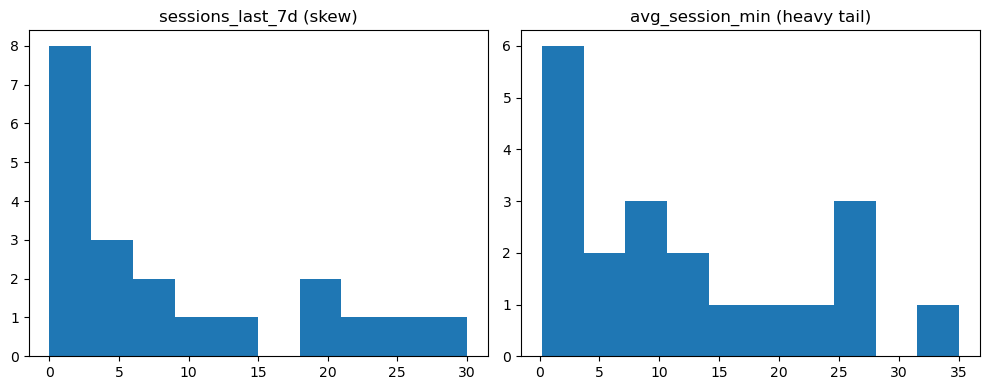

In [50]:
# TODO: pick 2 columns and create 2 plots that reveal something non-trivial
# Example: sessions_last_7d (skew), avg_session_min (heavy tail), tenure_days (range)
plt.figure(figsize=(10,4)) # creates a new figure with specified size, width=10 inches, height=4 inches
plt.subplot(1,2,1) # 1 row, 2 columns, first subplot
# TODO
# Histogram
plt.hist(df['sessions_last_7d'], bins=10) # bins 10 means it divides data into 10 equal intervals
plt.title('sessions_last_7d (skew)') # title of the plot
plt.subplot(1,2,2)
plt.hist(df['avg_session_min'], bins=10) # Histogram
plt.title('avg_session_min (heavy tail)') # title of the plot
# TODO
plt.tight_layout()
plt.show()


## 3) Target + Slices — 15 minutes


### Task 3.1: Label imbalance


In [51]:
# TODO: compute churn rate and counts
# Label Imbalance = class imbalance , it happens when for my dataset for classification purposes- classes are not equally represented.
# here class meaning the target variable 'churned' has imbalanced classes 0 and 1
churn_rate = float(df['churned'].mean()) # df['churned] is going to give me a series of 0s and 1s. 
# 0 means no churned and 1 means churned and then mean is going to compute avg
counts = df['churned'].value_counts().rename_axis('churned').to_frame('n')
# df['churned'].value_counts() = how many time each unique value appears in the 'churned' column,
# unique values in churned are 0 or 1 -  how many times 0 appears and how many times 1 appears
print(churn_rate)
counts   # how many times 0 and 1 appears




# dataframe means it contains rows and columns - 2D

# series , consider it as a single column of data - 1D [0,1,0,0,1,1,0]

# Checkpoint: which metric would you choose (accuracy vs F1 vs PR-AUC) and why?


0.3


,n
churned,
0,14
1,6


### Task 3.2: Slice analysis


In [52]:
# TODO: compute churn rate by country and by plan
# slice refers to subset of data 
# slice analysis is a technique to see how it performs on specific subsets of data 

by_country = df.groupby('country')['churned'].mean().sort_values(ascending=False)

# group by 'plan' and then look at churned column(which has 0 and 1) and compute mean , then sort values in descending order
by_plan = df.groupby('plan')['churned'].mean().sort_values(ascending=False) 
# by_country
by_plan

# TODO: create a tenure bucket column and compute churn by bucket
# HINT: pd.cut 
df2 = df.copy()
df2["tenure_bucket"] = pd.cut(df2['tenure_days'], bins=[-1,14,60,180,10_000], labels=['<=2w','2w-2m','2m-6m','6m'])
by_bucket = df2.groupby('tenure_bucket')['churned'].mean().sort_values(ascending=False)
by_bucket


tenure_bucket
<=2w     0.75
2w-2m    0.50
2m-6m    0.20
6m       0.00
Name: churned, dtype: float64

## 4) Leakage + Time — 10 minutes


### Task 4.1: Identify leakage-prone features


In [53]:
# TODO: identify columns that likely leak label or post-outcome info.
# HINT: refund_after_churn_flag looks suspicious.
# Leakage prone feature - those features which give away the target variable or outcome information
# I would not like to use something which is not available at prediction time.
# Means i should takle those features carefully , i should not give to the model during prediction
# 'Refund after churn'is the column that i shouldn't have.

leaky_cols = None
leaky_cols

# TODO: write 2-3 sentences explaining why each is leaky (prediction-time availability).


## 5) Homework — EDA Write-up


In 10–15 bullets:
- Top 5 data issues/risks
- Top 3 features to create next
- What you would do before training any model
